# Week 10: $k$-means and elbows

## Goals:
- See strengths and weaknesses of $k$-means
- Elbow plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.cluster import KMeans

## Examples with $k$-means

We will use the $k$-means algorithm in `sci-kit learn`, but I want the basic version. 

You can find more details about the [$k$-means algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) from `sci-kit learn`.

So here's a wrapper function to give us the basic $k$-means algorithm.

In [2]:
def BasicKMeans(k, data):
    return KMeans(n_clusters=k, init='random', n_init=1).fit(data)

Let's create another wrapper function to stop after one iteration, so randomly select and then one more step.

In [3]:
def BasicKMeans_2(k, data):
    return KMeans(n_clusters=k, init='random', n_init=1, max_iter=1).fit(data)

The following code will produce nice Voronoi tessellations, given the data points and centroids.

In [4]:
def Voronoi(data, kmeans=None):
    import numpy as np
    import matplotlib.pyplot as plt 

    x_min = (data.T)[0].min()
    x_max = (data.T)[0].max()
    y_min = (data.T)[1].min()
    y_max = (data.T)[1].max()
    ma = max(x_max, y_max)
    mi = min(x_min, y_min)
    x_min -= (ma - mi)/20
    y_min -= (ma - mi)/20
    x_max += (ma - mi)/20
    y_max += (ma - mi)/20

    plt.figure(1)
    plt.clf()
    if kmeans:
        incr = 0.01
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, incr), 
            np.arange(y_min, y_max, incr)
        )
        Z = np.c_[xx.ravel(), yy.ravel()]
        L = kmeans.predict(Z)
        L = L.reshape(xx.shape)
        plt.imshow(
            L,
            interpolation="nearest",
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap=plt.cm.Paired,
            aspect="auto",
            origin="lower",
        )
        plt.tick_params(
            left = False, 
            right = False, 
            labelleft = False, 
            labelbottom = False, 
            bottom = False
        )
    plt.scatter(data[:,0], data[:,1], c="black")    
    if kmeans:
        cents = kmeans.cluster_centers_
        plt.scatter(cents[:,0], cents[:,1], c="white", marker="x", linewidths=2, s=100)
    return plt

### A Clear Case

First we will look at the data set `three_clusters_clear.csv`. We will plot this with `Voronoi`.

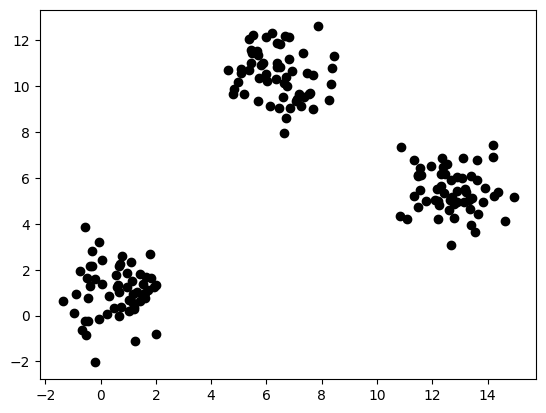

In [5]:
data_3c = pd.read_csv("data/three_clusters_clear.csv").to_numpy()
plot = Voronoi(data_3c)

In [8]:
kmeans_data_3c = BasicKMeans(3, data_3c)
print(kmeans_data_3c.cluster_centers_)

[[ 6.44212389 10.50868003]
 [ 0.5682233   1.06867418]
 [12.72207651  5.44466063]]


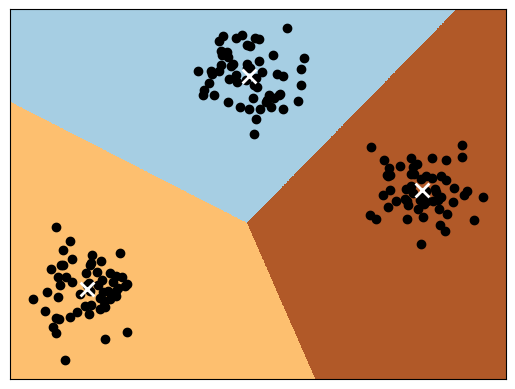

In [9]:
plot = Voronoi(data_3c, kmeans=kmeans_data_3c)

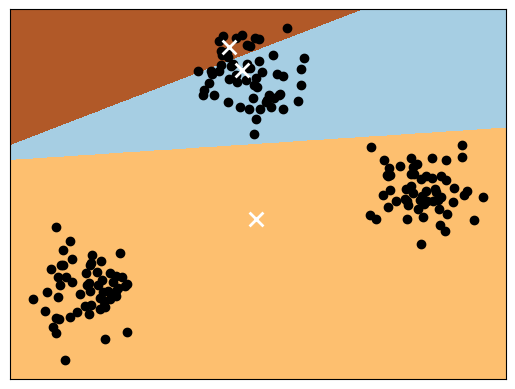

In [13]:
plot = Voronoi(data_3c, kmeans=BasicKMeans_2(3, data_3c))

### Not So Clear Case

Now we will load the `three_clusters_vague.csv` data set, which still has three clusters.

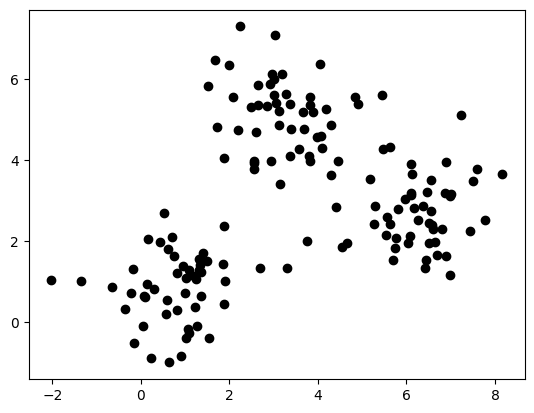

In [14]:
data_3v = pd.read_csv("data/three_clusters_vague.csv").to_numpy()
plot = Voronoi(data_3v)

In [15]:
kmeans_data_3v = BasicKMeans(3, data_3v)
print(kmeans_data_3v.cluster_centers_)

[[3.23621461 5.1101824 ]
 [0.80545702 0.84470154]
 [6.22860904 2.69931237]]


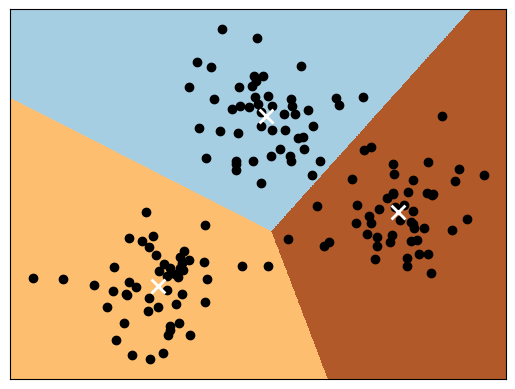

In [20]:
plot = Voronoi(data_3v, kmeans=kmeans_data_3v)

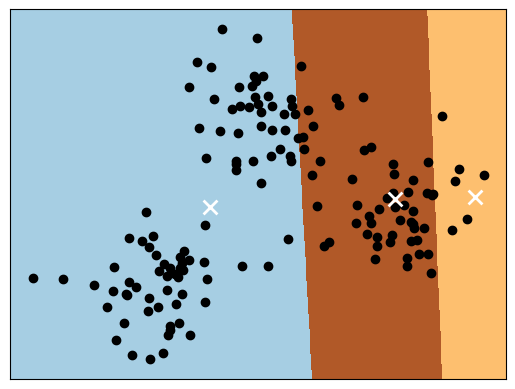

In [23]:
plot = Voronoi(data_3v, kmeans=BasicKMeans_2(3, data_3v))

### Clear but 'unbalanced'

Now we will load a new data set where $k$-means is sometimes 'successful'.

**Note.** $k$-means is neither successful or unsuccessful. It does what it does. 'Success' is based on our definition of what the clusters ought to be in the data. 

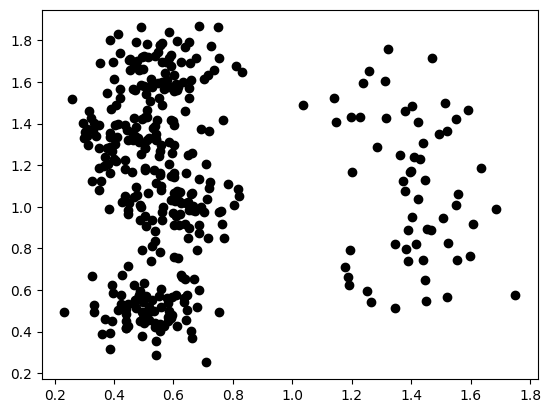

In [24]:
data_2u = np.array(pd.read_csv("data/two_clusters_unbalanced.csv"))
plot = Voronoi(data_2u)

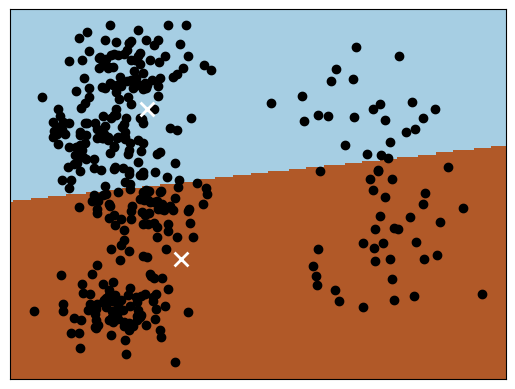

In [34]:
plot = Voronoi(data_2u, kmeans=BasicKMeans(2, data_2u))

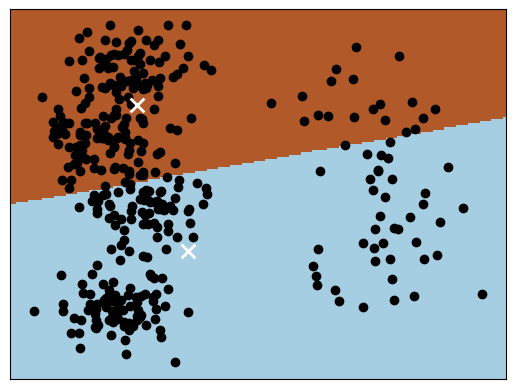

In [35]:
plot = Voronoi(data_2u, kmeans=BasicKMeans_2(2, data_2u))

### An impossible data set

We'll load a data set that is not meant for $k$-means at all. (Why???)

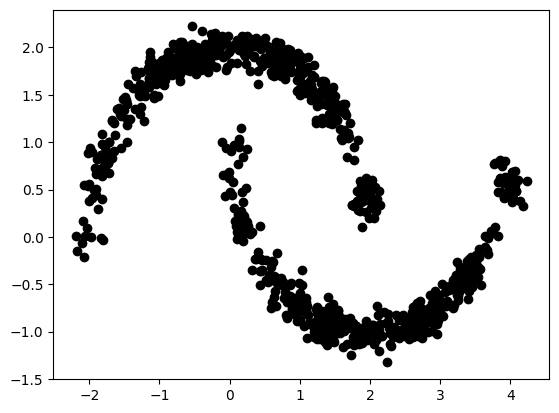

In [36]:
data_imp = np.array(pd.read_csv("data/impossible.csv"))
plot = Voronoi(data_imp)

It would reasonable to say that are either $2$, $3$, $4$, $5$, or even $6$ clusters. 

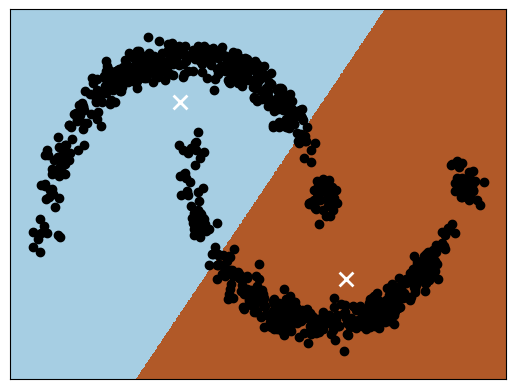

In [41]:
plot = Voronoi(data_imp, kmeans=BasicKMeans(2, data_imp))

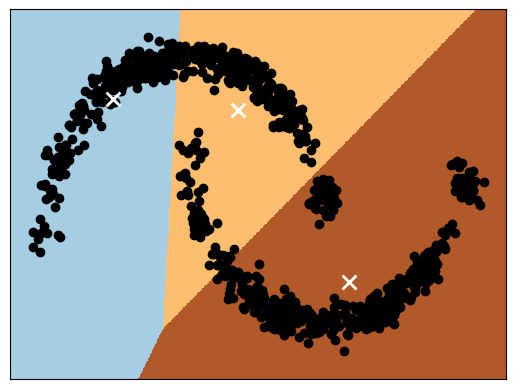

In [47]:
plot = Voronoi(data_imp, kmeans=BasicKMeans(3, data_imp))

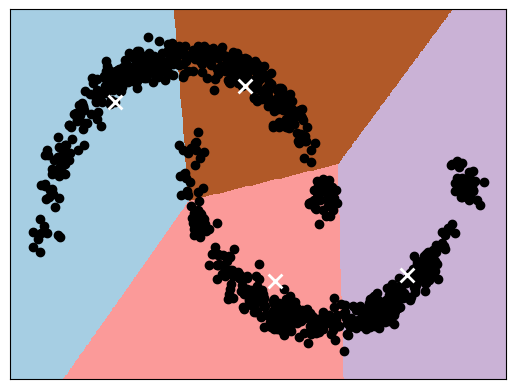

In [51]:
plot = Voronoi(data_imp, kmeans=BasicKMeans(4, data_imp))

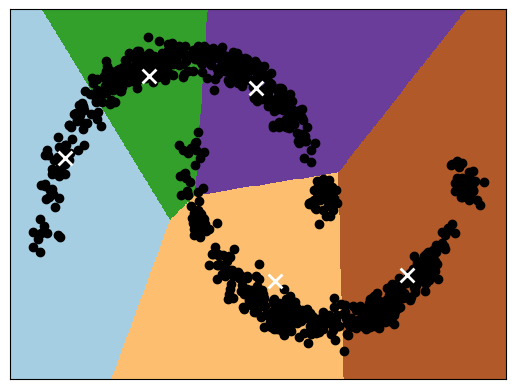

In [52]:
plot = Voronoi(data_imp, kmeans=BasicKMeans(5, data_imp))

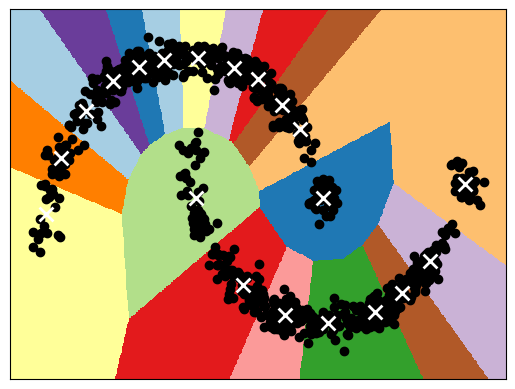

In [55]:
plot = Voronoi(data_imp, kmeans=BasicKMeans(20, data_imp))

This is hopeless... This just happens to be an example that would be handled very well with *single-linkage clustering*.

While $k$-means is powerful, it shouldn't be used on *every* data set. 

## Elbow method

In all of our examples, it was somewhat easy to see how many clusters there were 'supposed' to be.

It would be nice if we knew beforehand how many clusters there are in the data.

This is ill-posed, so there is no perfect way, but one way to figure out a good choice for $k$ is with the elbow method. 

Important to the elbow method is the Within-Cluster Sum of Squares (WCSS):
$$
    \text{WCSS} = \sum_{i=1}^k \sum_{x \in C_i} \| x - c_i \|^2,
$$

where $C_i$ is the $i^{\text{th}}$ cluster and $c_i$ is the centroid associated with the $i^{\text{th}}$ cluster. 

#### What is WCSS?

The idea behind WCSS is that smaller is better. However, if each data point is its own centroid, then $\mathrm{WCSS} = 0$. 

Thus, the elbow method ultimately seeks a balance between low WCSS (lots of clusters) and low $k$ values. 

Let's create some code to compute WCSS. The input will be our data array and our kmeans data.

In [56]:
def WCSS(data, kmeans):
    from functools import reduce

    ord_cents = map(lambda i: kmeans.cluster_centers_[i], kmeans.labels_)
    tups = zip(data, ord_cents)
    dist2 = lambda t: np.linalg.norm(t[0] - t[1])**2
    
    return reduce(lambda x, y: x + dist2(y), tups, 0)

The elbow method looks at the plot of WCSS values against $k$ values and looks for an 'elbow' in the graph.

An 'elbow' is not rigoriously defined, so again the elbow method does not always work. 

An 'elbow' is the point at which the graph changes slope most sharply, and it should be signifcant.

Let's build code to look at an elbow plot.

In [57]:
def ElbowMethodPlot(data, N):
    import matplotlib.pyplot as plt

    KMEANS = [BasicKMeans(k, data) for k in range(1, N + 1)]
    WCSS_vals = [WCSS(data, kmeans) for kmeans in KMEANS]

    plt.figure(1)
    plt.grid()
    plt.plot(WCSS_vals)
    plt.xticks(ticks=range(N), labels=range(1, N+1))
    return plt

Let's look at the first data set `three_clusters_clear.csv` which is stored in `data_3c`.

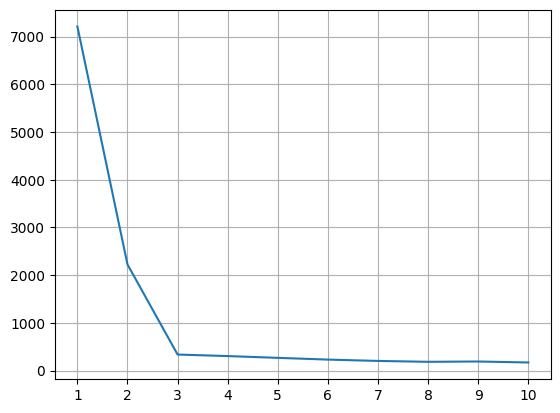

In [59]:
plot = ElbowMethodPlot(data_3c, 10)

The 'elbow' occurs at $k=3$ suggesting that there are 'supposed' to be $3$ clusters.

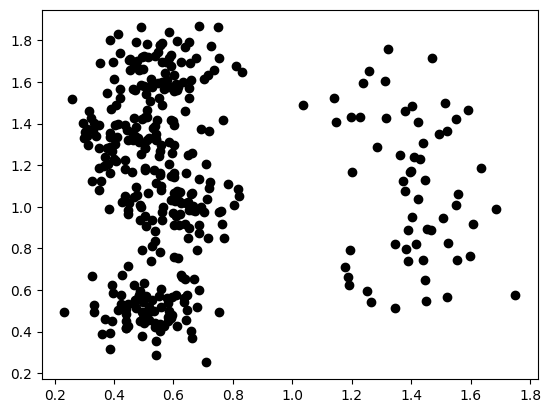

In [63]:
plot = Voronoi(data_2u)

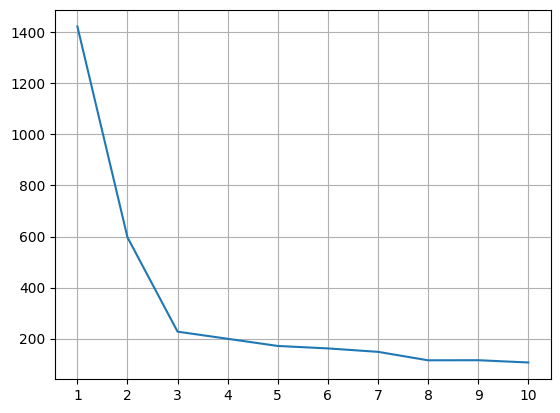

In [61]:
plot = ElbowMethodPlot(data_3v, 10)

The elbow method does not always work.

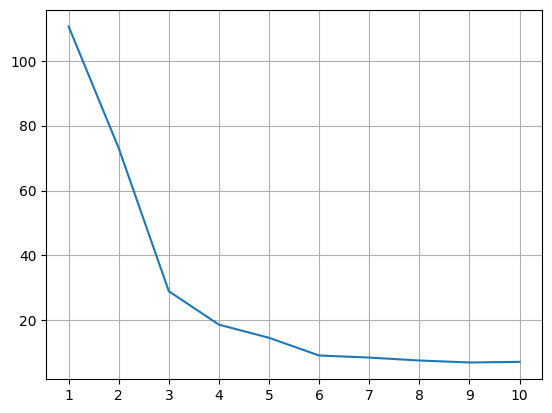

In [67]:
plot = ElbowMethodPlot(data_2u, 10)

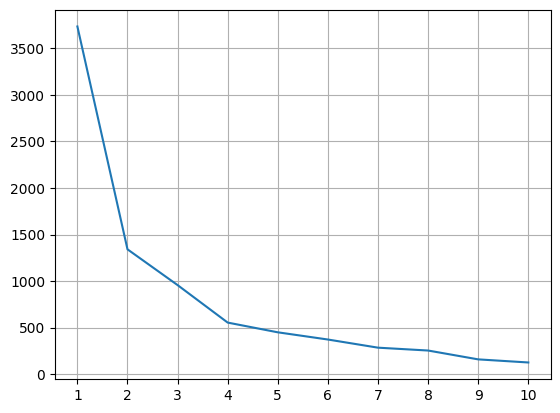

In [69]:
plot = ElbowMethodPlot(data_imp, 10)

## Do it yourself 

There are five data sets to play around with. Feel free to use the functions here: `Voronoi`, `BasicKMeans`, `ElbowMethodPlot`.

Here are some question to consider.
1. How many clusters are there in the data? 
2. Do the clusters seem to be unambiguous? 
3. What other intrepretations are there?
4. Does the $k$-means clustering do what you expect? Why? 

Discuss this with a neighbour.

Data sets:
- `extra_1.csv`
- `extra_2.csv`
- `extra_3.csv`
- `extra_4.csv`
- `extra_5.csv`

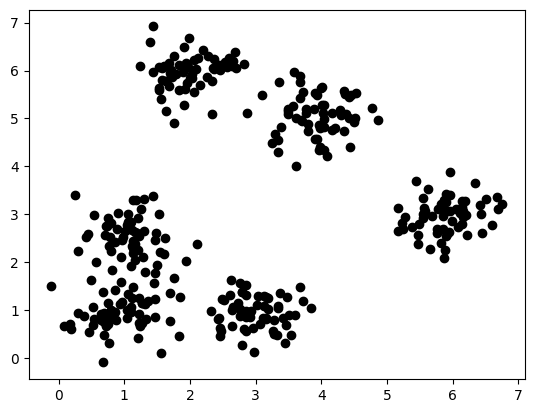

In [82]:
data = np.array(pd.read_csv("data/extra_1.csv"))
plot = Voronoi(data)
# _ = ElbowMethodPlot(data, 10)